# **Machine Learning Project: Anti-Money Laundering Detection - XGBoost**

- Author: Dantong Liu 刘丹彤

- Email: dantongliu1999@outlook.com

- LinkedIn: http://linkedin.com/in/dantong-liu-273271311

# Summary
In this project, I applied **XGBoost**, a Supervised Learning method, to detect various types of money laundering transactions.

* **Data Exploration:** I first conducted a statistical analysis of the features and identified a significant **class imbalance**. Specifically, money laundering transactions were far less frequent compared to normal transactions.
* **Preprocessing:** To prepare the data, I converted categorical features into numeric values using a **label encoder**. I also **standardized** the 'Amount' feature and addressed the class imbalance issue using **SMOTE** (Synthetic Minority Over-sampling Technique) to generate additional instances of money laundering transactions.
* **Model Tuning:** I built a parameter grid to perform **hyperparameter tuning**. However, due to hardware limitations (my friend assisted by running the code on her server with 200GB RAM and multi-core support, but it still took over 10 hours to complete), I was only able to search a limited parameter space.
* **Training and Results:** Using the best parameters from the grid search, I trained the XGBoost model. Unfortunately, the **validation curve** indicated underfitting. A wider parameter grid search might yield more optimal results. Additionally, the evaluation on the test set showed that the **F1-score** was low, particularly for detecting money laundering transactions.
* **Conclusion:** The training results are consistent with a reference paper that used a random forest model, which also had difficulty detecting complex money laundering patterns, such as Fan-in and Fan-out schemes. XGBoost has the potential to perform better with a more extensive hyperparameter search or changing to detect 'True or False' rather than money laundering types.


# Reference
- Datasets: https://www.kaggle.com/datasets/berkanoztas/synthetic-transaction-monitoring-dataset-aml

- Oztas, B., Cetinkaya, D., Adedoyin, F., Budka, M., Dogan, H., & Aksu, G. (2023, November). Enhancing Anti-Money Laundering: Development of a Synthetic Transaction Monitoring Dataset. In 2023 IEEE International Conference on e-Business Engineering (ICEBE) (pp. 47-54). IEEE.


In [ ]:
import joblib
import pandas as pd
import numpy as np

# input - full size data 973 MB
df = pd.read_csv('/kaggle/input/synthetic-transaction-monitoring-dataset-aml/SAML-D.csv')

# drop NAN
df = df.dropna()


features = ['Sender_account', 'Receiver_account', 'Amount', 'Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type', 'Is_laundering', 'Laundering_type', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']

In [ ]:
# data description

def calculate_value_percentages(df, columns):

    results = {}
    for column in columns:
        value_counts = df[column].value_counts()
        percentages = (value_counts / len(df)) * 100
        results[column] = pd.DataFrame({
            'Value': value_counts.index,
            'Count': value_counts.values,
            'Percentage': percentages.values
        })

    return results

columns_to_analyze = [
    'Payment_currency', 'Received_currency', 'Sender_bank_location',
    'Receiver_bank_location', 'Payment_type', 'Is_laundering',
    'Laundering_type'
]

results = calculate_value_percentages(df, columns_to_analyze)

for column, result_df in results.items():
    print(f"Column: {column}")
    print(result_df)
    print("\n")



# data description
amount_description = df['Amount'].describe()

print(amount_description)

Column: Payment_currency
              Value    Count  Percentage
0         UK pounds  9099293   95.733137
1              Euro   117164    1.232676
2      Turkish lira    27996    0.294544
3       Swiss franc    27492    0.289242
4            Dirham    27263    0.286832
5   Pakistani rupee    27196    0.286128
6             Naira    27143    0.285570
7         US dollar    26061    0.274186
8               Yen    25562    0.268936
9   Moroccan dirham    25395    0.267179
10     Mexican Peso    24852    0.261466
11     Albanian lek    24778    0.260688
12     Indian rupee    24657    0.259415


Column: Received_currency
              Value    Count  Percentage
0         UK pounds  8783655   92.412328
1              Euro   231911    2.439922
2   Pakistani rupee    45993    0.483890
3               Yen    45814    0.482006
4   Moroccan dirham    45748    0.481312
5      Albanian lek    45736    0.481186
6      Mexican Peso    45255    0.476125
7             Naira    45046    0.473926
8   

In [ ]:
# datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S')

# year, month, day, hour, minute, second
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

df['Hour'] = df['Time'].dt.hour
df['Minute'] = df['Time'].dt.minute
df['Second'] = df['Time'].dt.second

df = df.drop(columns=['Time', 'Date'])

In [ ]:
# only select 50% sample data because of the RAM limit.
df_XGB = df.sample(frac=0.5, random_state=666)

import gc
del df
gc.collect()

print(df_XGB.head())


         Sender_account  Receiver_account    Amount Payment_currency  \
2213931      2926822786        3660533052   5101.81        UK pounds   
1689106      7520572110        3280038273   5999.16        UK pounds   
5830232      5360300017        5684966754  13108.66        UK pounds   
8693610      9307956421        9703591276    313.69        UK pounds   
2375959      1786832968        8257468687   2592.45        UK pounds   

        Received_currency Sender_bank_location Receiver_bank_location  \
2213931         UK pounds                   UK                     UK   
1689106         UK pounds                   UK                     UK   
5830232         UK pounds                   UK                     UK   
8693610         UK pounds                   UK                     UK   
2375959         UK pounds                   UK                     UK   

            Payment_type  Is_laundering         Laundering_type  Year  Month  \
2213931           Cheque              0         

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline
from sklearn.metrics import accuracy_score
import seaborn as sns

In [ ]:
# LabelEncoder
label_columns = ['Payment_type', 'Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Sender_account', 'Receiver_account', 'Laundering_type']

label_encoders = {}
for col in label_columns:
    le = LabelEncoder()
    df_XGB[col] = le.fit_transform(df_XGB[col])
    label_encoders[col] = le

preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['Amount'])  # StandardScaler
    ],
    remainder='passthrough'
)

In [ ]:
df_XGB[['Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type', 'Is_laundering',  'Laundering_type', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']] = df_XGB[['Payment_currency', 'Received_currency', 'Sender_bank_location', 'Receiver_bank_location', 'Payment_type', 'Is_laundering', 'Laundering_type', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second']].astype('int8')
df_XGB[['Sender_account', 'Receiver_account']] = df_XGB[['Sender_account', 'Receiver_account']].astype('int32')
df_XGB[['Amount']] = df_XGB[['Amount']].astype('float32')

df_XGB.dtypes

Sender_account              int32
Receiver_account            int32
Amount                    float32
Payment_currency             int8
Received_currency            int8
Sender_bank_location         int8
Receiver_bank_location       int8
Payment_type                 int8
Is_laundering                int8
Laundering_type              int8
Year                         int8
Month                        int8
Day                          int8
Hour                         int8
Minute                       int8
Second                       int8
dtype: object

In [ ]:
# X & Y
X = df_XGB.drop(columns=['Is_laundering', 'Laundering_type'])
y = df_XGB['Laundering_type']    # multiclass


# split: train 70%, cross validation 15%, test 15%
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
# SMOTE
smote = SMOTE(random_state=42, n_jobs=-1)

pipeline = imPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', smote)
])

X_train_res, y_train_res = pipeline.fit_resample(X_train, y_train)


/opt/conda/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Before running the below cell, please noted that it will spend more 10 hours in the 200GB RAM and multi kernels environment.

Following cells are finished in PyChram, I paste the results as Markdown.

In [ ]:
# find the best parameters
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1
)

param_grid = {
    'max_depth': [4],
    'min_child_weight': [6],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'alpha': [0.1, 1],
    'reg_lambda': [1, 5],
    'learning_rate': [0.01, 0.05]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid,
                           scoring='accuracy', cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train_res, y_train_res)

# best parameters
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Best parameters found: {'alpha': 0.1, 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 6, 'reg_lambda': 5, 'subsample': 0.8}

Best parameters found: {'alpha': 0.1, 'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 6, 'reg_lambda': 5, 'subsample': 0.8}

In [ ]:
# preprocess validation set and test set
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)


In [ ]:
# train
xgb_model_best = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    n_jobs=-1,
    alpha=0.1,
    colsample_bytree=0.8,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=6,
    reg_lambda=5,
    subsample=0.8,
    n_estimators=80
)

eval_set = [(X_train_res, y_train_res), (X_val_processed, y_val)]

xgb_model_best.fit(X_train_res, y_train_res,
                   eval_set= eval_set,
                   verbose=True)


[0]	validation_0-mlogloss:3.20218	validation_1-mlogloss:3.22381
[1]	validation_0-mlogloss:3.08138	validation_1-mlogloss:3.16407
[2]	validation_0-mlogloss:2.99877	validation_1-mlogloss:3.08288
[3]	validation_0-mlogloss:2.93198	validation_1-mlogloss:3.03523
[4]	validation_0-mlogloss:2.87524	validation_1-mlogloss:2.97750
[5]	validation_0-mlogloss:2.81923	validation_1-mlogloss:2.92029
[6]	validation_0-mlogloss:2.76776	validation_1-mlogloss:2.87131
[7]	validation_0-mlogloss:2.71844	validation_1-mlogloss:2.83891
[8]	validation_0-mlogloss:2.67321	validation_1-mlogloss:2.79746
[9]	validation_0-mlogloss:2.63356	validation_1-mlogloss:2.76156
[10]	validation_0-mlogloss:2.59666	validation_1-mlogloss:2.73290
[11]	validation_0-mlogloss:2.55971	validation_1-mlogloss:2.69636
[12]	validation_0-mlogloss:2.52347	validation_1-mlogloss:2.66352
[13]	validation_0-mlogloss:2.49282	validation_1-mlogloss:2.63366
[14]	validation_0-mlogloss:2.46617	validation_1-mlogloss:2.60727
[15]	validation_0-mlogloss:2.43655	

XGBClassifier(alpha=0.1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=80,
              n_jobs=-1, num_parallel_tree=None, ...)

In [ ]:
# save model
xgb_model_best-save_model("923xgb_model json")
xgb_model_best.save_model("D:\Bkaka\pycode\XGB\923xgb_model.json")

In [ ]:
# load model
xgb_model_best = xgb.Booster()
xgb_model_best.load_model("D:\Bkaka\pycode\XGB\923xgb_model.json")

In [ ]:
# Validation Accuracy
y_val_pred = xgb_model_best.predict(X_val_processed)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")


Validation Accuracy: 0.44143904026574493


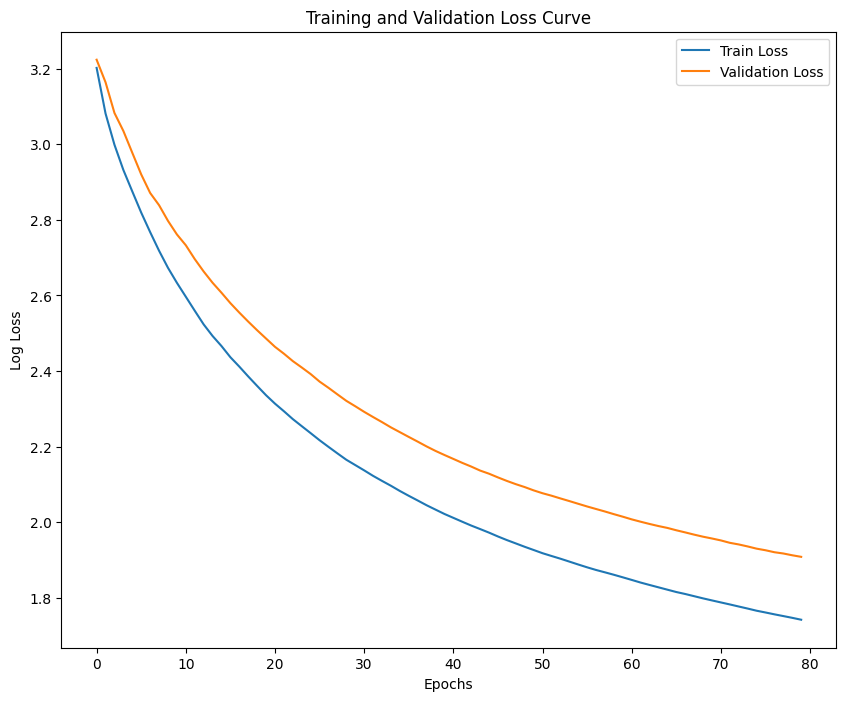

In [ ]:
# Validation Loss Curve
results = xgb_model_best.evals_result()
epochs = len(results['validation_0']['mlogloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 8))
plt.plot(x_axis, results['validation_0']['mlogloss'], label='Train Loss')
plt.plot(x_axis, results['validation_1']['mlogloss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.savefig('dataset\'Training and Validation Loss Curve.jpg')
plt.show()

Test Accuracy: 0.44154705525878707


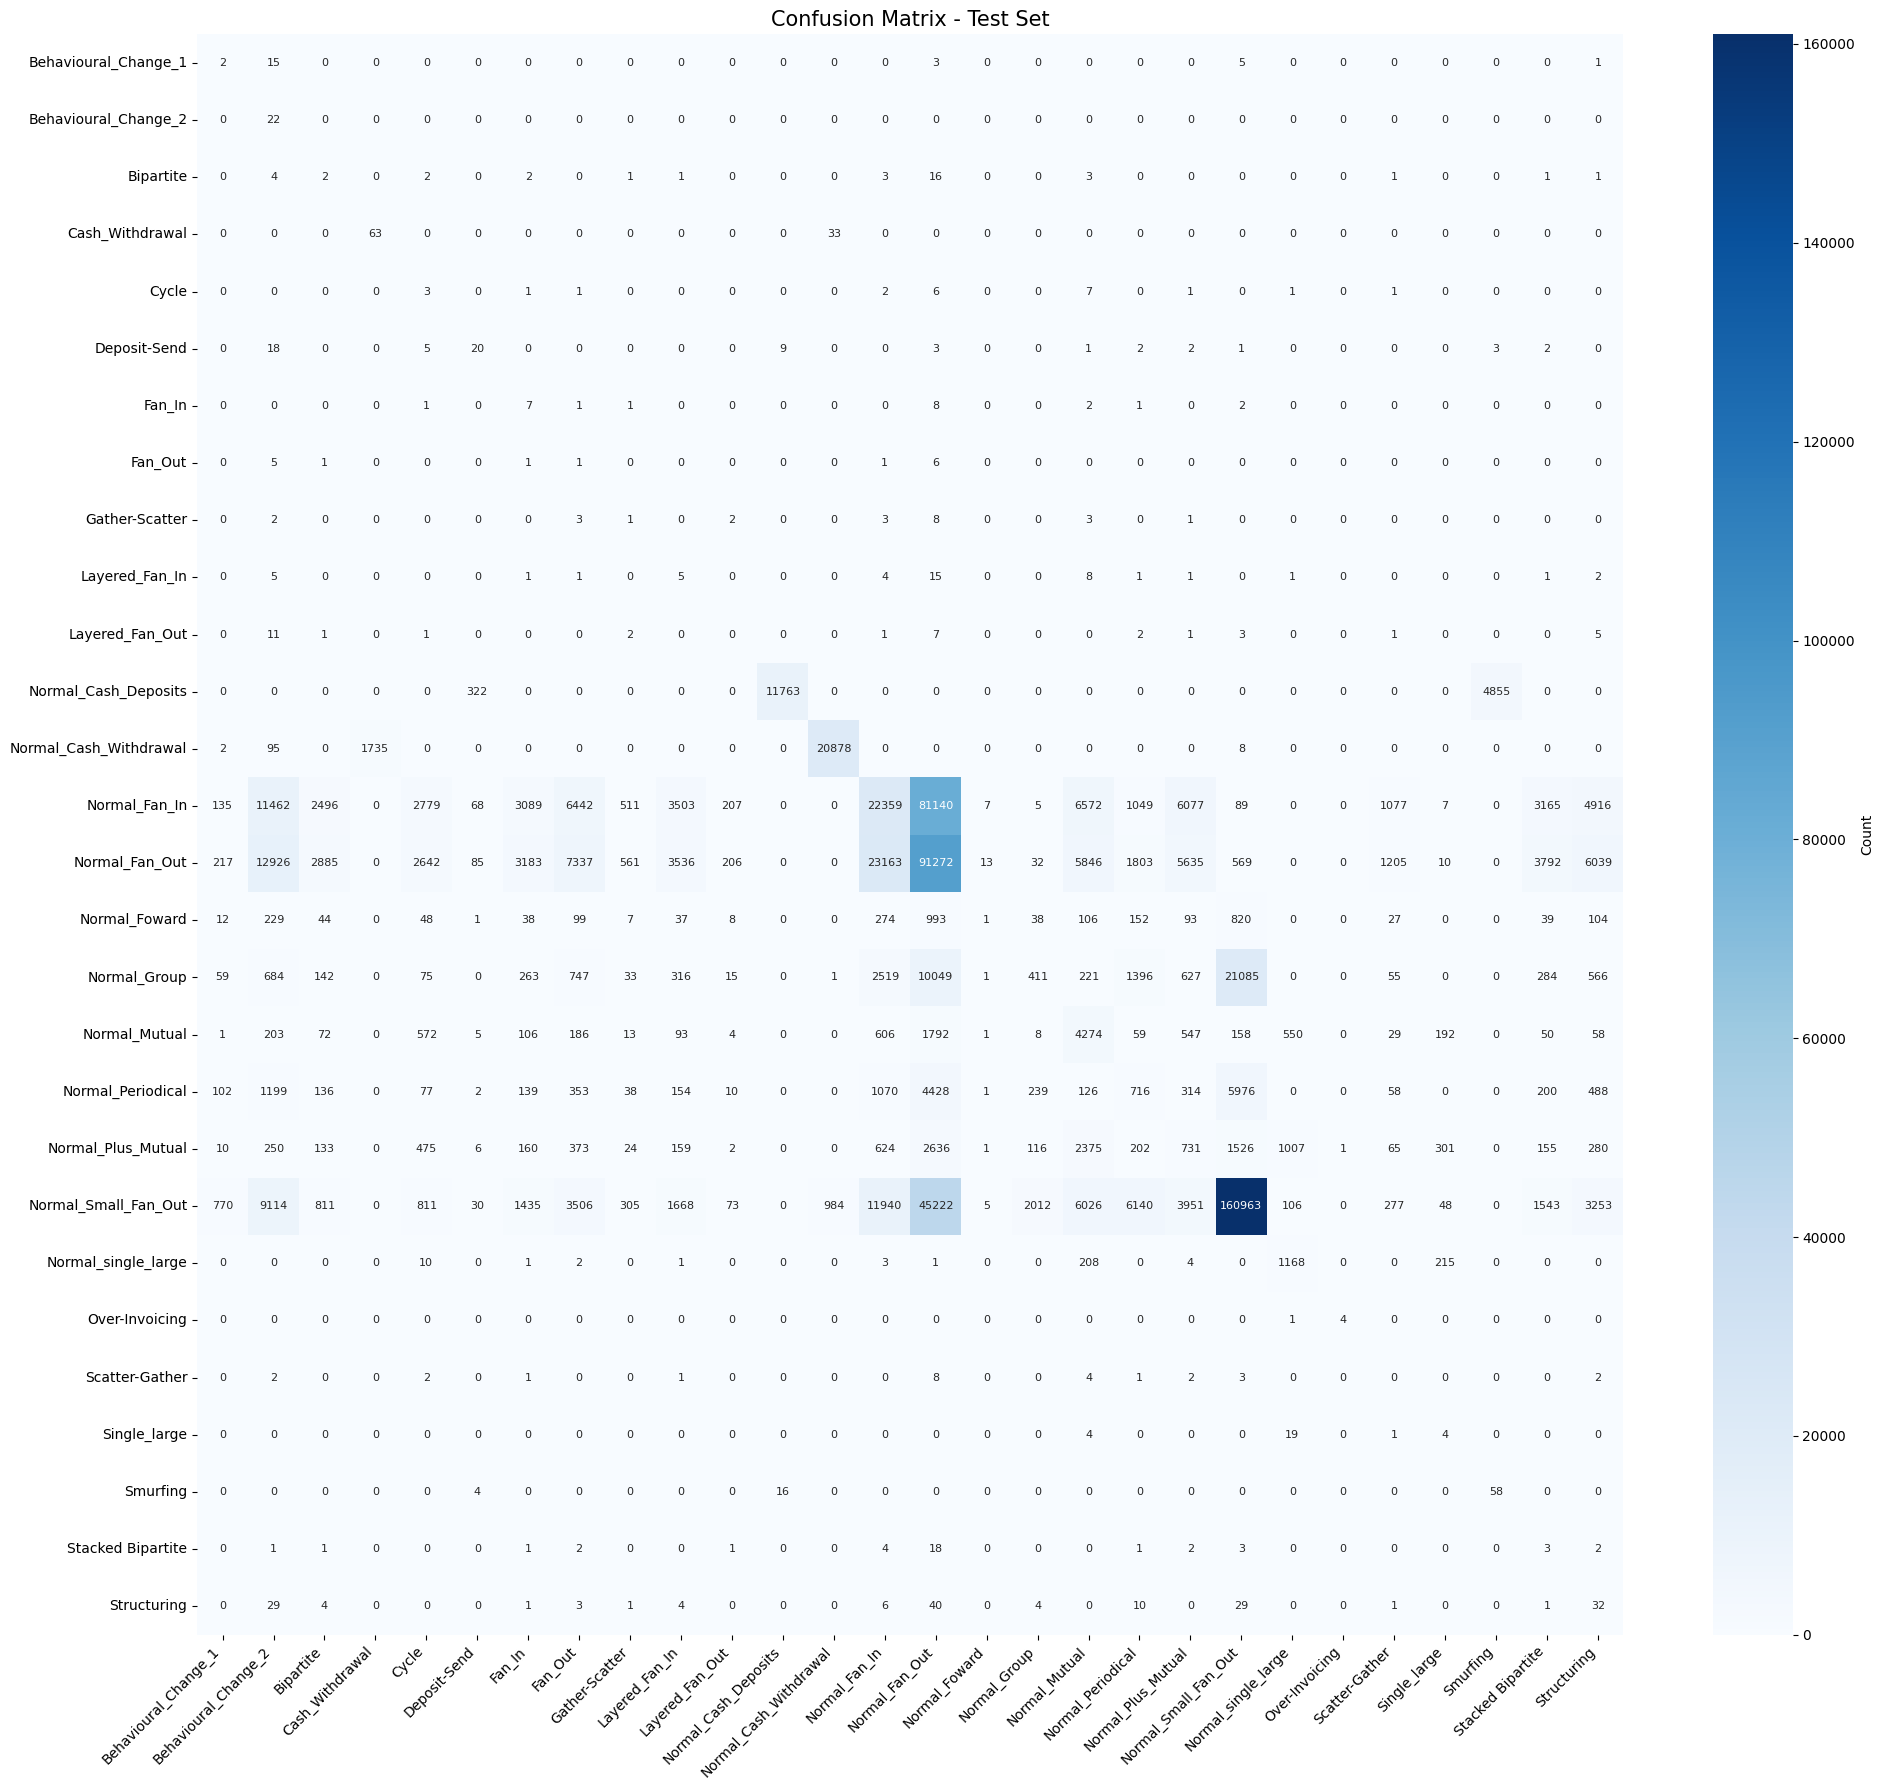

In [ ]:
# Test Accuracy
y_test_pred = xgb_model_best.predict(X_test_processed)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Confusion Matrix - Test Set
y_test_pred_original = label_encoders['Laundering_type'].inverse_transform(y_test_pred)
y_test_original = label_encoders['Laundering_type'].inverse_transform(y_test)

cm_test = confusion_matrix(y_test_original, y_test_pred_original)

plt.figure(figsize=(20, 18))
ax = sns.heatmap(cm_test, annot=True, fmt='g', cmap='Blues',
                 xticklabels=label_encoders['Laundering_type'].classes_,
                 yticklabels=label_encoders['Laundering_type'].classes_,
                 annot_kws={"size": 8}, cbar_kws={'label': 'Count'})

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)
plt.title('Confusion Matrix - Test Set', fontsize=15)
plt.tight_layout()
# plt.savefig('dataset/Confusion_Matrix_Test_Set.jpg')
plt.show()

In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_test_original, y_test_pred_original))
# np.save("Classification_Report.txt",classification_report(y_test, y_test_pred, target_names=label_encoders.classes_))


Classification Report:
                        precision    recall  f1-score   support

  Behavioural_Change_1       0.00      0.08      0.00        26
  Behavioural_Change_2       0.00      1.00      0.00        22
             Bipartite       0.00      0.05      0.00        37
       Cash_Withdrawal       0.04      0.66      0.07        96
                 Cycle       0.00      0.13      0.00        23
          Deposit-Send       0.04      0.30      0.07        66
                Fan_In       0.00      0.30      0.00        23
               Fan_Out       0.00      0.07      0.00        15
        Gather-Scatter       0.00      0.04      0.00        23
        Layered_Fan_In       0.00      0.11      0.00        45
       Layered_Fan_Out       0.00      0.00      0.00        35
  Normal_Cash_Deposits       1.00      0.69      0.82     16940
Normal_Cash_Withdrawal       0.95      0.92      0.94     22718
         Normal_Fan_In       0.36      0.14      0.20    157155
        Normal_F